In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import copy
from numpy import savetxt, loadtxt

from preprocessor import Preprocessor
from models import Autoencoder, Generator, Discriminator
from randomized_smoothing import Smooth
from features_info import COLUMN_NAMES, BINARY_FEATURES, ATTACKS, PROBE_FUNCTIONAL_COLS, DOS_FUNCTIONAL_COLS, U2R_FUNCTIONAL_COLS, R2L_FUNCTIONAL_COLS

# Intrusion Detection System

The underlying IDS we use for this experiment is a deep autoencoder. This section includes the training of the IDS and its performance.

Load data for training and testing the IDS

In [2]:
# Hyperparameters for IDS
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 300
IDS_PATH = "./models/ids.pt"

In [3]:
train_ids = pd.read_csv("datasets/NSL-KDD/KDDTrain+_1.txt", header=None)
test = pd.read_csv("datasets/NSL-KDD/KDDTest+.txt", header=None)

preprocessor = Preprocessor(train_ids)
X_train_ids, _ = preprocessor.get_preprocessed(normal_only=True)
X_train_ids, X_val_ids = train_test_split(X_train_ids, test_size=0.1, random_state=42)

X_test, y_test = preprocessor.preprocess_another(test)

print(f"Training   : {X_train_ids.shape}\nValidation : {X_val_ids.shape}\nTesting    : {X_test.shape}")

train_loader = DataLoader(X_train_ids.to_numpy().astype(np.float32), batch_size=BATCH_SIZE)
val_loader = DataLoader(X_val_ids.to_numpy().astype(np.float32), batch_size=BATCH_SIZE)
test_loader = DataLoader(X_test.to_numpy().astype(np.float32), batch_size=BATCH_SIZE)

Training   : (30099, 122)
Validation : (3345, 122)
Testing    : (22544, 122)


Load the model from `IDS_PATH`. If file not found, start a new training and save at `IDS_PATH`.

In [4]:
def train(net, trainloader, validloader, NUM_EPOCHS):
    train_loss, val_loss = [], []
    min_val_loss = 100000
    best_model = None
    for epoch in range(NUM_EPOCHS):
        cur_train_loss = 0.0
        for data in trainloader:
            optimizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            cur_train_loss += loss.item()
        
        # evaluate validation loss
        cur_val_loss = 0.0
        with torch.no_grad():
            for data in validloader:
                outputs = net(data)
                loss = criterion(outputs, data)
                cur_val_loss += loss.item()
                
        cur_train_loss /= len(trainloader)
        cur_val_loss /= len(validloader)
        
        if cur_val_loss < min_val_loss:
            min_val_loss = cur_val_loss
            best_model = copy.deepcopy(net)
        train_loss.append(cur_train_loss)
        val_loss.append(cur_val_loss)
        print('Epoch {} of {}, Train Loss: {:.10f}, Validation Loss: {:.10f}'.format(
            epoch+1, NUM_EPOCHS, cur_train_loss, cur_val_loss))
         
 
    return best_model, train_loss, val_loss

try:
    # Load
    ids = torch.load(IDS_PATH)
    print("Loaded from", IDS_PATH)
    ids.eval()

except FileNotFoundError:
    
    print(IDS_PATH, "does not exist")
    print('Creating a new model...')
    criterion = nn.MSELoss()
    net = Autoencoder(criterion)
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    print(net)

    print('Starting training...')
    ids, train_loss, val_loss = train(net, train_loader, val_loader, NUM_EPOCHS)

    # Save
    torch.save(ids, IDS_PATH)
    print("Saved at", IDS_PATH)

Loaded from ./models/ids.pt


Score = 0.9517541841956778


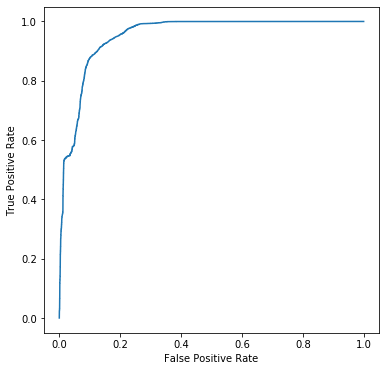

In [5]:
anomaly_scores = []
criterion = nn.MSELoss()

with torch.no_grad():
    for data in test_loader:
        y_hat = ids.score(data)
        anomaly_scores.append(y_hat)
anomaly_scores = torch.cat(anomaly_scores, 0)

ori_fpr, ori_tpr, ori_threshold = roc_curve(y_test, anomaly_scores)
plt.figure(figsize=(6,6))
plt.plot(ori_fpr, ori_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Score = ' + str(auc(ori_fpr, ori_tpr)))

Other models for comparison.

Training LR...
Training DT...
Training RF...
LR 		 Score = 0.837568
DT 		 Score = 0.804789
RF 		 Score = 0.959379
AE 		 Score = 0.952843


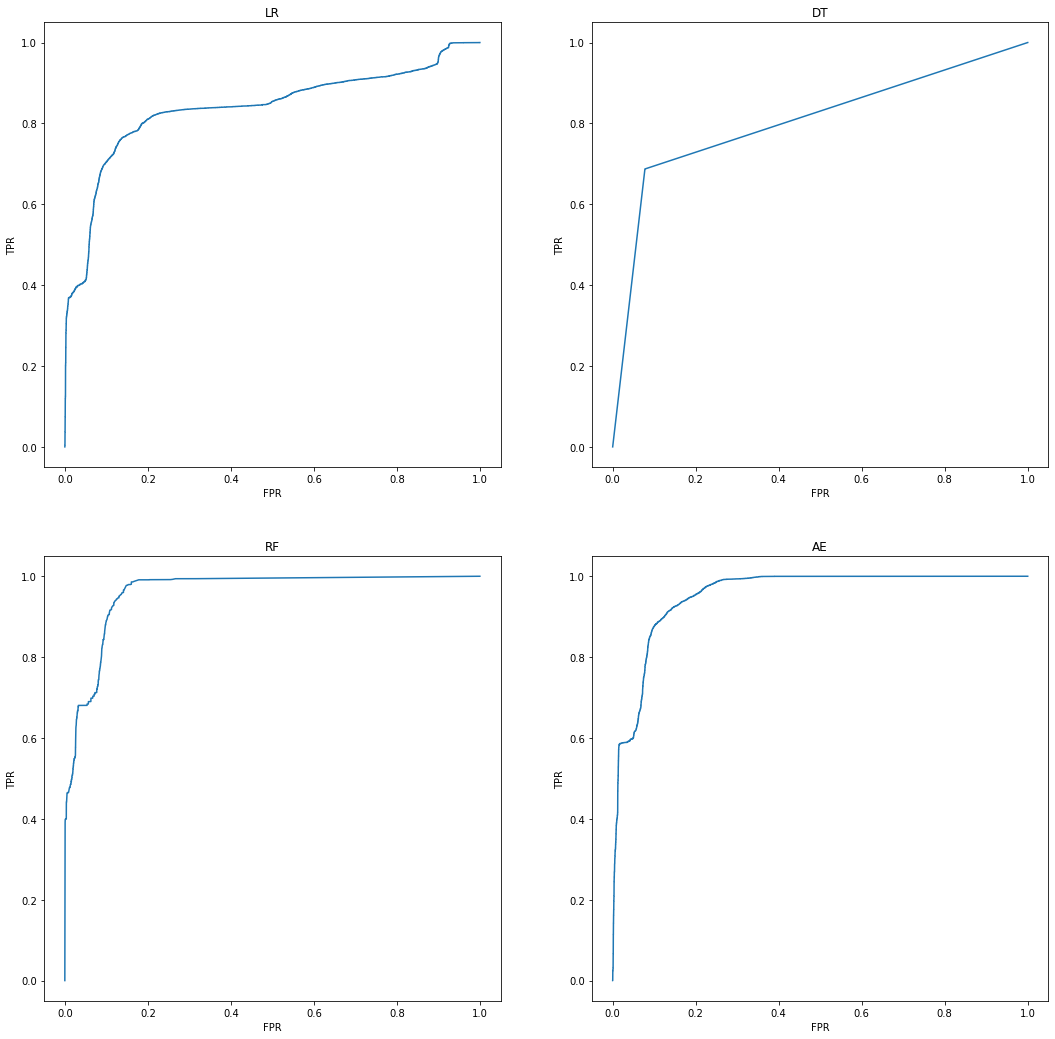

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

train_ids = pd.read_csv("datasets/NSL-KDD/KDDTrain+_1.txt", header=None)
test = pd.read_csv("datasets/NSL-KDD/KDDTest+.txt", header=None)

clf_models = {'LR': LogisticRegression(solver='lbfgs', max_iter=10000),
         'DT': DecisionTreeClassifier(),
         'RF': RandomForestClassifier(n_estimators=100)}

preprocessor = Preprocessor(train_ids)
X_train_ids, y_train_ids = preprocessor.get_preprocessed()
X_test, y_test = preprocessor.preprocess_another(test)

# Train classifiers
get_score_fn_clf = lambda clf: (lambda x: clf.predict_proba(x)[:,1])
for m in clf_models:
    print(f'Training {m}...')
    clf = clf_models[m].fit(X_train_ids, y_train_ids)
    clf.score = get_score_fn_clf(clf) # add score method to be consistent with our autoencoder

# add our autoencoder
ae = torch.load(IDS_PATH)
ae.eval()
clf_models['AE'] = ae

fig, axs = plt.subplots(2, 2, figsize=(18,18))
axss = [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]

print("="*100)

# Plot ROC curve
clf_rocs = {}
for m, a in zip(clf_models, axss):
    clf = clf_models[m]
    pred = clf.score(torch.tensor(X_test.values.astype(np.float32)))
    fpr, tpr, threshold = roc_curve(y_test, pred)
    a.plot(fpr, tpr)
    a.set_xlabel('FPR')
    a.set_ylabel('TPR')
    
    clf_rocs[m] = (fpr, tpr)
    a.set_title(m)
    
    print("{} \t\t Score = {:3f}".format(m, auc(fpr, tpr)))
    
plt.show()

# Fast Gradient Sign Method

In [9]:
EPSILON = 0.02

ids = torch.load(IDS_PATH)
print("Loaded from", IDS_PATH)
ids.eval()

# generate adversarial data
criterion = nn.MSELoss()
X_test_tensor = torch.tensor(X_test.to_numpy().astype(np.float32))
X_test_tensor.requires_grad = True
output = ids(X_test_tensor)
loss = criterion(output, X_test_tensor)
loss.backward()

X_test_fgsm = X_test_tensor + EPSILON * torch.sign(X_test_tensor.grad)
fgsm_test_loader = DataLoader(X_test_fgsm, batch_size=BATCH_SIZE)

Loaded from ./models/ids.pt


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Score = 0.8517349443007972


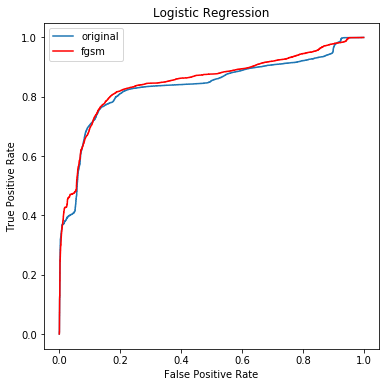

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Score = 0.49472236130362446


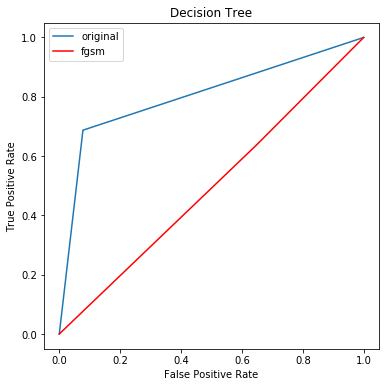

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Score = 0.7764940562350102


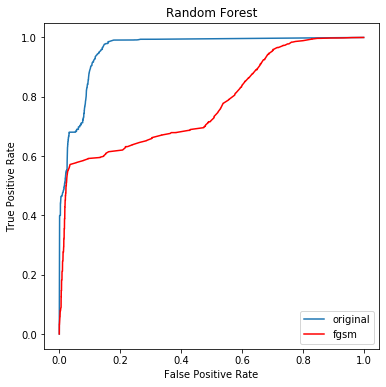

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Score = 0.8664572272871285


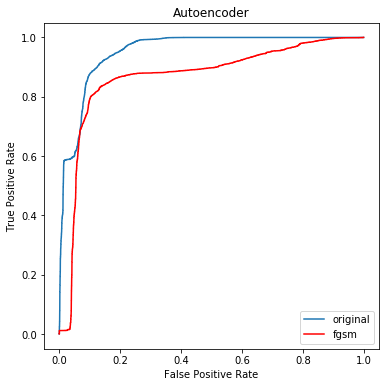

In [10]:
map_to_full_name = {
    'LR': 'Logistic Regression',
    'DT': 'Decision Tree',
    'RF': 'Random Forest',
    'AE': 'Autoencoder'
}

for m in clf_models:
    ids = clf_models[m]
    anomaly_scores = []
    with torch.no_grad(): 
        for data in fgsm_test_loader:
            y_hat = ids.score(data)
            anomaly_scores.append(torch.tensor(y_hat))
    anomaly_scores = torch.cat(anomaly_scores, 0)

    fgsm_fpr, fgsm_tpr, fgsm_threshold = roc_curve(y_test, anomaly_scores)
    plt.figure(figsize=(6,6))
    ori_fpr, ori_tpr = clf_rocs[m]
    plt.plot(ori_fpr, ori_tpr, label='original')
    plt.plot(fgsm_fpr, fgsm_tpr, label='fgsm', color='red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(map_to_full_name[m])
    plt.legend()
    plt.savefig(f'./results/fgsm_roc_{m}_epsilon{EPSILON}.eps', format='eps')
    print('Score = ' + str(auc(fgsm_fpr, fgsm_tpr)))
    plt.show()

# Randomized Smoothing

In [11]:
SIGMA = [0.1, 0.2, 0.3, 0.4]
MIN_THRESHOLD = 0 # min threshold to try to get the roc curve
MAX_THRESHOLD = 1 # max threshold to try to get the roc curve

In [12]:
RERUN_SMOOTH = False

if RERUN_SMOOTH:
    for sigma in SIGMA:
        print(f"SIGMA = {sigma}")
        smooth = Smooth(ids, sigma)
        fprs, tprs, ars = smooth.get_fprs_tprs_ars(X_test_fgsm[:, None, None, :], y_test, MIN_THRESHOLD, MAX_THRESHOLD)

        savetxt(f'./results/fpr_fgsm01_smooth{sigma}.csv', fprs, delimiter=',')
        savetxt(f'./results/tpr_fgsm01_smooth{sigma}.csv', tprs, delimiter=',')
        savetxt(f'./results/ar_fgsm01_smooth{sigma}.csv', ars, delimiter=',') # abstain rate

Score (\sigma=0.4) = 0.8421373893972959
Score (\sigma=0.3) = 0.8259422438462223
Score (\sigma=0.2) = 0.8013066115360891
Score (\sigma=0.1) = 0.7613268830715013
Score (fgsm) = 0.6972983494798958


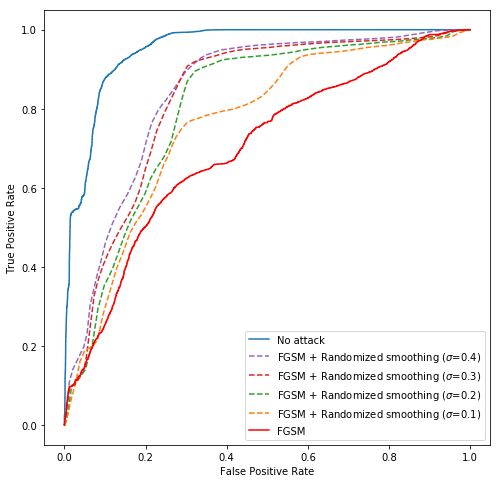

In [13]:
smoothing_data = {}
for sigma in SIGMA:
    fpr = loadtxt(f'./results/fpr_fgsm01_smooth{sigma}.csv', delimiter=',')
    tpr = loadtxt(f'./results/tpr_fgsm01_smooth{sigma}.csv', delimiter=',')
    ar  = loadtxt(f'./results/ar_fgsm01_smooth{sigma}.csv', delimiter=',')
    smoothing_data[sigma] = (fpr, tpr, ar)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(8,8))
plt.plot(ori_fpr, ori_tpr, label='No attack', color=colors[0])
for i, sigma in reversed(list(enumerate(smoothing_data))):
    fpr, tpr, _ = smoothing_data[sigma]
    plt.plot(fpr, tpr, 
             label=f'FGSM + Randomized smoothing ($\sigma$={sigma})', linestyle='dashed',color=colors[i+1])
    print(f"Score (\sigma={sigma}) = {auc(fpr, tpr)}")
plt.plot(fgsm_fpr, fgsm_tpr, label='FGSM', color='red')
print(f"Score (fgsm) = {auc(fgsm_fpr, fgsm_tpr)}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.savefig(f'./results/fgsm_smoothing.eps', format='eps')
plt.show()

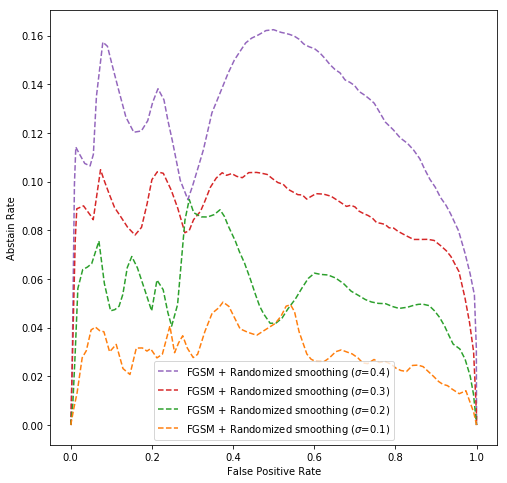

In [14]:
plt.figure(figsize=(8,8))
for i, sigma in reversed(list(enumerate(smoothing_data))):
    fpr, _, ar = smoothing_data[sigma]
    plt.plot(fpr, ar, 
             label=f'FGSM + Randomized smoothing ($\sigma$={sigma})', linestyle='dashed', color=colors[i+1])
plt.xlabel('False Positive Rate')
plt.ylabel('Abstain Rate')
plt.legend()
plt.savefig(f'./results/fgsm_smoothing_abstain.eps', format='eps')
plt.show()

# IDSGAN

Load data.

In [15]:
BATCH_SIZE = 64

train_idsgan = pd.read_csv("datasets/NSL-KDD/KDDTrain+_2.txt", header=None)
idsgan_preprocessor = Preprocessor(train_idsgan)
X_train_idsgan, y_train_idsgan = idsgan_preprocessor.get_preprocessed()
X_normal , X_attack = X_train_idsgan[y_train_idsgan == 0], X_train_idsgan[y_train_idsgan == 1]

# elements of y_attack is either Probe, DoS, U2R, or R2L
map_to_attack_type = {a: at for at in ATTACKS for a in ATTACKS[at]}
y_attack = train_idsgan['class'][train_idsgan['class'] != 'normal'].apply(lambda x: map_to_attack_type[x])

# indices of the non functional columns
probe_nonfunctional_ix = torch.tensor([X_attack.columns.get_loc(c) for c in X_attack.columns if c not in PROBE_FUNCTIONAL_COLS])
dos_nonfunctional_ix = torch.tensor([X_attack.columns.get_loc(c) for c in X_attack.columns if c not in DOS_FUNCTIONAL_COLS])
u2r_nonfunctional_ix = torch.tensor([X_attack.columns.get_loc(c) for c in X_attack.columns if c not in U2R_FUNCTIONAL_COLS])
r2l_nonfunctional_ix = torch.tensor([X_attack.columns.get_loc(c) for c in X_attack.columns if c not in R2L_FUNCTIONAL_COLS])

binary_ix = torch.tensor([X_attack.columns.get_loc(c) for c in BINARY_FEATURES])

X_attack_by_types = {
    'Probe' : X_attack[y_attack == 'Probe'],
    'DoS'   : X_attack[y_attack == 'DoS'],
    'R2L'   : X_attack[y_attack == 'R2L'],
    'U2R'   : X_attack[y_attack == 'U2R'],
}

print(f"X Probe shape = {X_attack_by_types['Probe'].shape}\n\
X DoS shape   = {X_attack_by_types['DoS'].shape}\n\
X U2R shape   = {X_attack_by_types['U2R'].shape}\n\
X R2L shape   = {X_attack_by_types['R2L'].shape}")

normal_loader = DataLoader(X_normal.to_numpy().astype(np.float32), batch_size=BATCH_SIZE)

X Probe shape = (5781, 122)
X DoS shape   = (22818, 122)
X U2R shape   = (25, 122)
X R2L shape   = (467, 122)


In [16]:
# Handpicked thresholds to get a classifier for training IDSGAN.
CLF_THRESHOLDS = {
    'LR': 0.25,
    'DT': 0.5,
    'RF': 0.1,
    'AE': 0.01,
}

Train IDSGAN.

In [25]:
# Change these 2 values to try other classifiers/attack types
#========================================================================
CLASSIFIER = 'AE' # {LR, DT, RF, AE}
ATTACK_TYPE = 'DoS' # {DoS, Probe, U2R, R2L}
#========================================================================

IDSGAN_G_PATH = f"./models/idsgan_g_{CLASSIFIER}_{ATTACK_TYPE}.pt"
IDSGAN_D_PATH = f"./models/idsgan_d_{CLASSIFIER}_{ATTACK_TYPE}.pt"

BATCH_SIZE = 64
MAX_EPOCH = 100
D_ITERS = 5
NOISE_DIM = 9
LEARNING_RATE = 0.0001
SAVE_INTERVAL = 10

CLAMP = 0.01

MAP_TO_NONFUNCTIONAL_IX = {
    'Probe': probe_nonfunctional_ix,
    'DoS'  : dos_nonfunctional_ix,
    'U2R'  : u2r_nonfunctional_ix,
    'R2L'  : r2l_nonfunctional_ix
}

def rescale(X_tensor, X_min, X_max, new_X_min, new_X_max):
    X = X_tensor.detach().numpy()
    X = X * (X_max - X_min) + X_min
    X = (X - new_X_min) / (new_X_max - new_X_min)
    X[~np.isfinite(X)] = 0
    return torch.tensor(X)

def process_generator_output(generator_outputs, orig_inputs, attack_type):
    ix = MAP_TO_NONFUNCTIONAL_IX[attack_type].expand(len(generator_outputs), -1)
    return orig_inputs.scatter(1, ix, generator_outputs)
    
def compute_gradient_penalty(D, normal_t, attack_t):
    alpha = torch.Tensor(np.random.random((normal_t.shape[0], 1)))
    between_n_a = (alpha * normal_t + ((1 - alpha) * attack_t)).requires_grad_(True)
    d_between_n_a = D(between_n_a)
    adv = torch.Tensor(normal_t.shape[0], 1).fill_(1.0).requires_grad_(False)

    gradients = torch.autograd.grad(
        outputs=d_between_n_a,
        inputs=between_n_a,
        grad_outputs=adv,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

def train_idsgan(ids_model, ids_threshold, normal_loader, X_attack, attack_type):
    print("IDSGAN start training")
    print("-"*100)
    
    count_features = X_attack.shape[1]

    generator = Generator(count_features + NOISE_DIM, len(MAP_TO_NONFUNCTIONAL_IX[attack_type]))
    discriminator = Discriminator(count_features, 1)

    print(generator)
    print(discriminator)
#     optimizer_G = optim.RMSprop(generator.parameters(), lr=LEARNING_RATE)
#     optimizer_D = optim.RMSprop(discriminator.parameters(), lr=LEARNING_RATE)
    optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)
    d_losses,g_losses = [],[]

    X_attack_vals = torch.tensor(X_attack.to_numpy().astype(np.float32))

    idsgan_min_bound, idsgan_max_bound = \
        idsgan_preprocessor.bounds[0].to_numpy().astype(np.float32), idsgan_preprocessor.bounds[1].to_numpy().astype(np.float32)
    ids_min_bound, ids_max_bound = \
        preprocessor.bounds[0].to_numpy().astype(np.float32), preprocessor.bounds[1].to_numpy().astype(np.float32)

    for epoch in range(MAX_EPOCH):

        run_attack_count, run_normal_count = 0., 0.
        for i, normal_batch in enumerate(normal_loader):
            if i % 50 == 0:
                print(f"    Batch {i}/{len(normal_loader)}")
            run_g_loss = 0.
            run_d_loss = 0.
            run_d_loss_normal, run_d_loss_attack = 0., 0.
            
            # discriminator training
            for p in discriminator.parameters():
                p.requires_grad = True

            for _ in range(D_ITERS):
                random_ix = torch.randint(0, len(X_attack_vals), (len(normal_batch),))
                attack_batch = X_attack_vals[random_ix]
                
                noise = torch.rand(attack_batch.shape[0], NOISE_DIM)
                adversarial_attack_batch = generator(torch.cat((attack_batch, noise), 1))
                adversarial_attack_batch = process_generator_output(adversarial_attack_batch, attack_batch, attack_type)
                inputs = torch.cat((adversarial_attack_batch, normal_batch)) 
                rescaled_inputs = rescale(inputs, idsgan_min_bound, idsgan_max_bound, ids_min_bound, ids_max_bound)
  
                ids_pred = np.array([1 if x >= ids_threshold else 0 for x in ids_model.score(rescaled_inputs)])
                normal_inputs = inputs[ids_pred == 0]
                attack_inputs = inputs[ids_pred == 1]
                
                run_normal_count += len(normal_inputs)
                run_attack_count += len(attack_inputs)
                if len(normal_inputs) == 0 or len(attack_inputs) == 0:
                    continue
                
                optimizer_D.zero_grad()
                normal_pred = discriminator(normal_inputs)
                attack_pred = discriminator(attack_inputs)
                loss_normal = torch.mean(normal_pred)
                loss_attack = torch.mean(attack_pred)
                
                run_d_loss_normal += loss_normal
                run_d_loss_attack += loss_attack
                
                gradient_penalty = compute_gradient_penalty(discriminator, normal_batch, adversarial_attack_batch)
                d_loss =  loss_normal - loss_attack + 10 * gradient_penalty
                d_loss.backward()
                optimizer_D.step()
                run_d_loss += d_loss.item()
                
#                 for p in discriminator.parameters(): 
#                     p.data.clamp_(-CLAMP, CLAMP)
                    
            # generator training
            for p in discriminator.parameters():  
                p.requires_grad = False

            random_ix = torch.randint(0, len(X_attack_vals), (BATCH_SIZE,))
            attack_batch = X_attack_vals[random_ix]
            
            optimizer_G.zero_grad()
            noise = torch.rand(attack_batch.shape[0], NOISE_DIM)
            outputs = generator(torch.cat((attack_batch, noise), 1))
            outputs = process_generator_output(outputs, attack_batch, attack_type)
            g_loss = torch.mean(discriminator(outputs))
            g_loss.backward()
            
            optimizer_G.step() 
            run_g_loss += g_loss.item()
    
        d_losses.append(run_d_loss/D_ITERS)
        g_losses.append(run_g_loss)
        print(f"{epoch} : g_loss = {run_g_loss} \t d_loss = {run_d_loss/D_ITERS}")
        print("     attack_count = {:3f}, normal_count = {:3f}"
              .format(run_attack_count/D_ITERS/len(normal_loader), run_normal_count/D_ITERS/len(normal_loader)))
        print("     d_loss_normal = {:3f}, d_loss_attack = {:3f}"
              .format(run_d_loss_normal/D_ITERS, run_d_loss_attack/D_ITERS))
        
        if epoch % SAVE_INTERVAL == 0:
            # Save
            torch.save(generator, IDSGAN_G_PATH + str(epoch))
            torch.save(discriminator, IDSGAN_D_PATH + str(epoch))
            
            print(f"SAVED AT {IDSGAN_G_PATH}, {IDSGAN_D_PATH}")

    print("IDSGAN finish training")
    return generator, discriminator, d_losses, g_losses

generator, discriminator, d_losses, g_losses = train_idsgan(clf_models[CLASSIFIER], 
                                        CLF_THRESHOLDS[CLASSIFIER], 
                                        normal_loader, 
                                        X_attack_by_types[ATTACK_TYPE], 
                                        ATTACK_TYPE)
# Save
torch.save(generator, IDSGAN_G_PATH)
torch.save(discriminator, IDSGAN_D_PATH)

IDSGAN start training
----------------------------------------------------------------------------------------------------
Generator(
  (layer): Sequential(
    (0): Linear(in_features=131, out_features=65, bias=True)
    (1): ReLU()
    (2): Linear(in_features=65, out_features=65, bias=True)
    (3): ReLU()
    (4): Linear(in_features=65, out_features=65, bias=True)
    (5): ReLU()
    (6): Linear(in_features=65, out_features=65, bias=True)
    (7): ReLU()
    (8): Linear(in_features=65, out_features=65, bias=True)
    (9): ReLU()
    (10): Linear(in_features=65, out_features=23, bias=True)
  )
)
Discriminator(
  (layer): Sequential(
    (0): Linear(in_features=122, out_features=61, bias=True)
    (1): ReLU()
    (2): Linear(in_features=61, out_features=61, bias=True)
    (3): ReLU()
    (4): Linear(in_features=61, out_features=61, bias=True)
    (5): ReLU()
    (6): Linear(in_features=61, out_features=61, bias=True)
    (7): ReLU()
    (8): Linear(in_features=61, out_features=61, bia

    Batch 450/530
    Batch 500/530
18 : g_loss = -0.009959564544260502 	 d_loss = -0.0001713862642645836
     attack_count = 63.972075, normal_count = 63.948679
     d_loss_normal = -0.010787, d_loss_attack = -0.010616
    Batch 0/530
    Batch 50/530
    Batch 100/530
    Batch 150/530
    Batch 200/530
    Batch 250/530
    Batch 300/530
    Batch 350/530
    Batch 400/530
    Batch 450/530
    Batch 500/530
19 : g_loss = -0.011410605162382126 	 d_loss = -0.000166378915309906
     attack_count = 63.940377, normal_count = 63.980377
     d_loss_normal = -0.011582, d_loss_attack = -0.011416
    Batch 0/530
    Batch 50/530
    Batch 100/530
    Batch 150/530
    Batch 200/530
    Batch 250/530
    Batch 300/530
    Batch 350/530
    Batch 400/530
    Batch 450/530
    Batch 500/530
20 : g_loss = -0.011731219477951527 	 d_loss = -0.00017102472484111785
     attack_count = 63.843396, normal_count = 64.077358
     d_loss_normal = -0.012118, d_loss_attack = -0.011947
SAVED AT ./model/idsga

    Batch 50/530
    Batch 100/530
    Batch 150/530
    Batch 200/530
    Batch 250/530
    Batch 300/530
    Batch 350/530
    Batch 400/530
    Batch 450/530
    Batch 500/530
40 : g_loss = 0.0012404716107994318 	 d_loss = -0.00026533945929259063
     attack_count = 64.058491, normal_count = 63.862264
     d_loss_normal = 0.000975, d_loss_attack = 0.001240
SAVED AT ./model/idsgan_g_AE_DoS.pt, ./model/idsgan_d_AE_DoS.pt
    Batch 0/530
    Batch 50/530
    Batch 100/530
    Batch 150/530
    Batch 200/530
    Batch 250/530
    Batch 300/530
    Batch 350/530
    Batch 400/530
    Batch 450/530
    Batch 500/530
41 : g_loss = 0.004111579619348049 	 d_loss = -0.0002595771104097366
     attack_count = 64.059623, normal_count = 63.861132
     d_loss_normal = 0.003842, d_loss_attack = 0.004101
    Batch 0/530
    Batch 50/530
    Batch 100/530
    Batch 150/530
    Batch 200/530
    Batch 250/530
    Batch 300/530
    Batch 350/530
    Batch 400/530
    Batch 450/530
    Batch 500/530
42 

    Batch 350/530
    Batch 400/530
    Batch 450/530
    Batch 500/530
61 : g_loss = 0.010886049829423428 	 d_loss = -0.000265190564095974
     attack_count = 64.061509, normal_count = 63.859245
     d_loss_normal = 0.010627, d_loss_attack = 0.010893
    Batch 0/530
    Batch 50/530
    Batch 100/530
    Batch 150/530
    Batch 200/530
    Batch 250/530
    Batch 300/530
    Batch 350/530
    Batch 400/530
    Batch 450/530
    Batch 500/530
62 : g_loss = 0.010812168009579182 	 d_loss = -0.00027146749198436737
     attack_count = 64.062264, normal_count = 63.858491
     d_loss_normal = 0.010552, d_loss_attack = 0.010824
    Batch 0/530
    Batch 50/530
    Batch 100/530
    Batch 150/530
    Batch 200/530
    Batch 250/530
    Batch 300/530
    Batch 350/530
    Batch 400/530
    Batch 450/530
    Batch 500/530
63 : g_loss = 0.010815811343491077 	 d_loss = -0.0002661464735865593
     attack_count = 64.062264, normal_count = 63.858491
     d_loss_normal = 0.010551, d_loss_attack = 0.01

    Batch 50/530
    Batch 100/530
    Batch 150/530
    Batch 200/530
    Batch 250/530
    Batch 300/530
    Batch 350/530
    Batch 400/530
    Batch 450/530
    Batch 500/530
83 : g_loss = 0.010828603990375996 	 d_loss = -0.00026370268315076826
     attack_count = 64.062264, normal_count = 63.858491
     d_loss_normal = 0.010557, d_loss_attack = 0.010820
    Batch 0/530
    Batch 50/530
    Batch 100/530
    Batch 150/530
    Batch 200/530
    Batch 250/530
    Batch 300/530
    Batch 350/530
    Batch 400/530
    Batch 450/530
    Batch 500/530
84 : g_loss = 0.010842792689800262 	 d_loss = -0.00026161950081586837
     attack_count = 64.061132, normal_count = 63.859623
     d_loss_normal = 0.010568, d_loss_attack = 0.010830
    Batch 0/530
    Batch 50/530
    Batch 100/530
    Batch 150/530
    Batch 200/530
    Batch 250/530
    Batch 300/530
    Batch 350/530
    Batch 400/530
    Batch 450/530
    Batch 500/530
85 : g_loss = 0.010878334753215313 	 d_loss = -0.000262370705604553

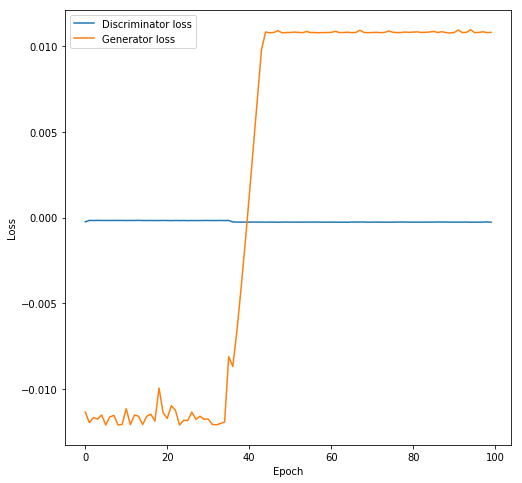

In [27]:
plt.figure(figsize=(8,8))
plt.plot(d_losses, label='Discriminator loss')
plt.plot(g_losses, label='Generator loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss_ae_idsgan1.eps', format='eps')
plt.show()

In [ ]:
# Load
generator = torch.load(IDSGAN_G_PATH)
discriminator = torch.load(IDSGAN_D_PATH)

Test IDSGAN.

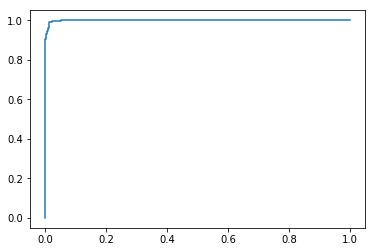

In [28]:
def process_binary(generator_outputs, binary_ix):
    for ix in binary_ix:
        generator_outputs[:, ix] = torch.round(generator_outputs[:, ix])
    return generator_outputs

test = pd.read_csv("datasets/NSL-KDD/KDDTest+.txt", header=None)
X_test, y_test = idsgan_preprocessor.preprocess_another(test)

test.columns = COLUMN_NAMES
X_test_attack = X_test[test['class'].apply(lambda x: x != 'normal' and map_to_attack_type[x] == ATTACK_TYPE)]
X_test_normal = X_test[test['class'] == 'normal']

test_attack_loader = DataLoader(X_test_attack.to_numpy().astype(np.float32), batch_size=64)
X_test_attack_idsgan = []
for attack_batch in test_attack_loader:
    noise = torch.rand(len(attack_batch), NOISE_DIM)
    adversarial_attack = generator(torch.cat([attack_batch, noise], 1))
    adversarial_attack = process_generator_output(adversarial_attack, attack_batch, 'DoS')
    adversarial_attack = process_binary(adversarial_attack, binary_ix)
    X_test_attack_idsgan.append(adversarial_attack)
    
X_test_attack_idsgan = torch.cat(X_test_attack_idsgan)
X_test_idsgan = torch.cat([X_test_attack_idsgan, 
                           torch.tensor(X_test_normal.to_numpy().astype(np.float32))])

idsgan_min_bound, idsgan_max_bound = \
    idsgan_preprocessor.bounds[0].to_numpy().astype(np.float32), idsgan_preprocessor.bounds[1].to_numpy().astype(np.float32)
ids_min_bound, ids_max_bound = \
    preprocessor.bounds[0].to_numpy().astype(np.float32), preprocessor.bounds[1].to_numpy().astype(np.float32)
X_test_idsgan = rescale(X_test_idsgan, idsgan_min_bound, idsgan_max_bound, ids_min_bound, ids_max_bound)


pred = clf_models[CLASSIFIER].score(X_test_idsgan)
y_test = np.concatenate([np.ones(len(X_test_attack)), np.zeros(len(X_test_normal))])

fpr, tpr, th = roc_curve(y_test, pred)
plt.plot(fpr, tpr)
plt.show()